In [1]:
import os
import pandas as pd
import json
import seaborn as sns
from typing import List

from experiments.interpretation.interpretation_util import (
    ExperimentFiles,
    ExperimentFolders,
)


# Base directory setup
notebook_dir = os.path.abspath("")
base_experiment_dir = os.path.join(
    notebook_dir, "..", "results", "experiments", ExperimentFolders.GPT_41
)


# Function to load all experiment files into DataFrames
def load_experiment_data(files: List[ExperimentFiles], base_dir: str) -> pd.DataFrame:
    dfs = []
    for file in files:
        path = os.path.join(base_dir, file)
        try:
            with open(path, "r", encoding="utf-8") as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            df["experiment_name"] = file  # Add column to identify the experiment
            dfs.append(df)
        except Exception as e:
            print(f"Failed to load {file}: {e}")
    return pd.concat(dfs, ignore_index=True)


# Load all experiments
all_files = list(ExperimentFiles)
df = load_experiment_data(all_files, base_experiment_dir)

# Now you can compare/filter by experiment_name
print(df["experiment_name"].value_counts())

experiment_name
triage_local.json                              91
all_tools_local.json                           91
all_tools_local_no_ranking.json                91
triage_mcp.json                                91
triage_mcp_seq_websearch.json                  91
all_tools_mcp_websearch.json                   91
all_tools_mcp_seq.json                         91
all_tools_mcp_seq_websearch.json               91
all_tools_mcp_seq_websearch_no_ranking.json    91
Name: count, dtype: int64


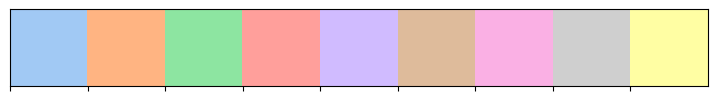

In [2]:
my_palette = sns.color_palette("pastel", 9)

sns.palplot(my_palette)

# Data Preparation

In [ ]:
# Strip .json and map to CONF codes
name_map = {
    "all_tools_local_no_ranking": "CONF-1",
    "all_tools_local": "CONF-2",
    "all_tools_mcp_seq": "CONF-3",
    "all_tools_mcp_websearch": "CONF-4",
    "all_tools_mcp_seq_websearch_no_ranking": "CONF-5",
    "all_tools_mcp_seq_websearch": "CONF-6",
    "triage_local": "CONF-7",
    "triage_mcp": "CONF-8",
    "triage_mcp_seq_websearch": "CONF-9",
}

# Strip .json, map to CONF code
df["experiment_name"] = df["experiment_name"].str.replace(".json", "", regex=False)
df["experiment_name"] = df["experiment_name"].map(name_map)

# Optional: verify if any names failed to map (e.g. got NaN)
unmapped = df["experiment_name"].isna().sum()
if unmapped > 0:
    print(f"Warning: {unmapped} rows have unmapped experiment names.")

# Sort by experiment_name (CONF-X)
df = df.sort_values(
    by="experiment_name", key=lambda col: col.str.extract(r"CONF-(\d+)")[0].astype(int)
)

# Direct Fact Score

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_58736/570716707.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


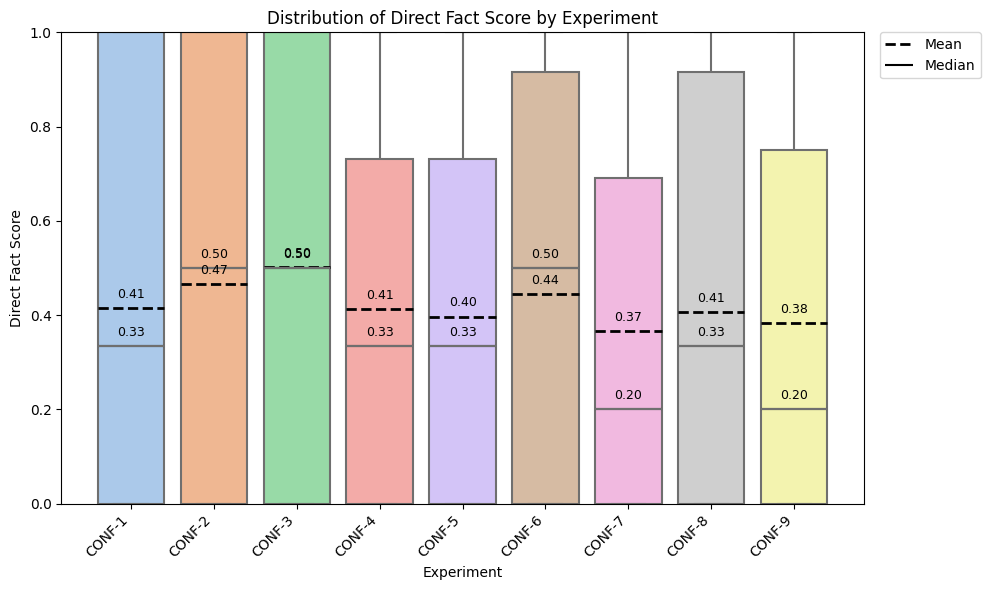

In [4]:
import matplotlib.pyplot as plt

import numpy as np

plt.figure(figsize=(10, 6))

# Draw boxplot and save the axis object
ax = sns.boxplot(
    data=df,
    x="experiment_name",
    y="fact_score.direct_fact_score",
    palette=my_palette,
    showfliers=False,
    linewidth=1.5,
)

# Get the x-tick positions (center of each box)
xticks = ax.get_xticks()
xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]

# Compute statistics
means = df.groupby("experiment_name")["fact_score.direct_fact_score"].mean()
medians = df.groupby("experiment_name")["fact_score.direct_fact_score"].median()

# Map experiment names to positions
pos_map = {label: pos for label, pos in zip(xticklabels, xticks)}

# Overlay mean line and median label
for i, (experiment, pos) in enumerate(pos_map.items()):
    mean_val = means.get(experiment)
    median_val = medians.get(experiment)

    if mean_val is not None:
        # Mean (red dashed line)
        plt.hlines(
            mean_val,
            pos - 0.40,
            pos + 0.40,
            colors="black",
            linestyles="--",
            linewidth=2,
            label="Mean" if i == 0 else "",  # Label only once
        )
        plt.text(
            pos,
            mean_val + 0.015,
            f"{mean_val:.2f}",
            color="black",
            va="bottom",
            fontsize=9,
            ha="center",
        )

    if median_val is not None:
        # Median label (black)
        plt.hlines(
            median_val,
            pos - 0.40,
            pos + 0.40,
            colors="black",
            linestyles="-",
            linewidth=1.5,
            label="Median" if i == 0 else "",  # Label only once
        )
        plt.text(
            pos,
            median_val + 0.015,
            f"{median_val:.2f}",
            color="black",
            va="bottom",
            fontsize=9,
            ha="center",
        )

# Final formatting
plt.title("Distribution of Direct Fact Score by Experiment")
plt.xlabel("Experiment")
plt.ylabel("Direct Fact Score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")

# Add legend outside top right
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=labels,
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
)

plt.tight_layout()
plt.show()

# Agent as a judge outcome

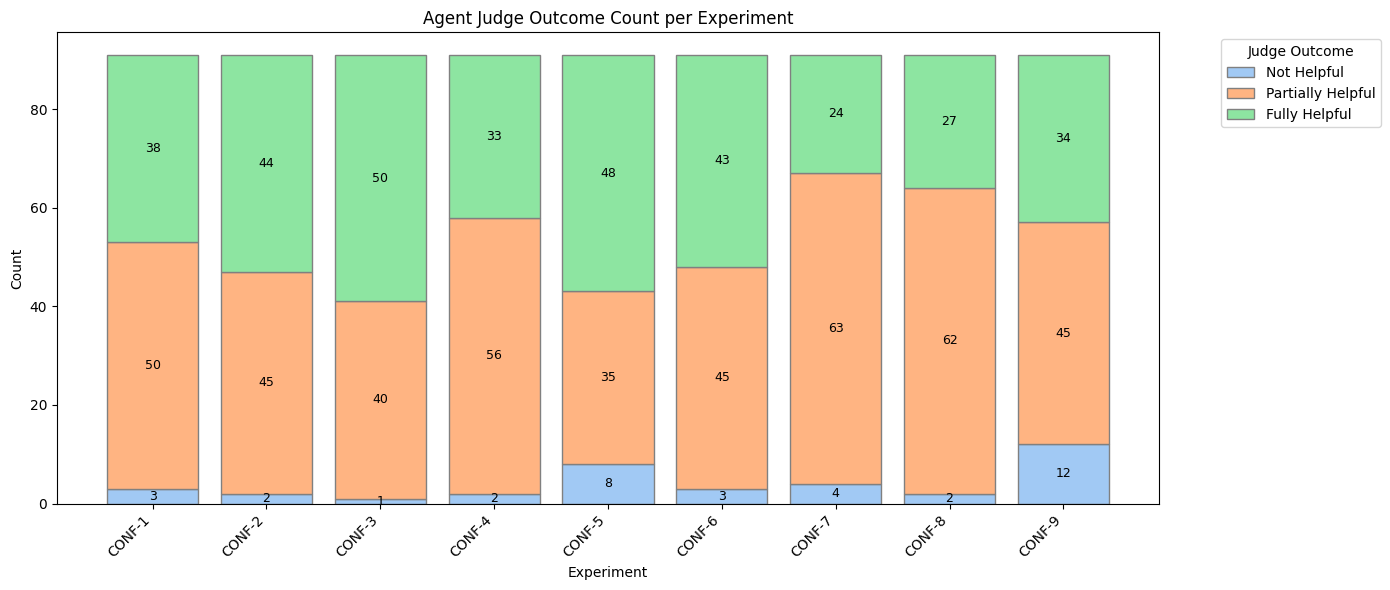

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data
stacked_data = (
    df.groupby(["experiment_name", "agent_judge_outcome"]).size().unstack(fill_value=0)
)

# Desired outcome stacking order
desired_order = ["Not Helpful", "Partially Helpful", "Fully Helpful"]
stacked_data = stacked_data[desired_order]

# Sort experiment names like CONF-1, CONF-2, etc.
stacked_data = stacked_data.reindex(
    sorted(stacked_data.index, key=lambda x: int(x.split("-")[1]))
)

# Plot
plt.figure(figsize=(14, 6))
bottom = [0] * len(stacked_data)

for idx, outcome in enumerate(desired_order):
    values = stacked_data[outcome].values
    bars = plt.bar(
        stacked_data.index,
        values,
        bottom=bottom,
        label=outcome,
        color=my_palette[idx],
        edgecolor="gray",
    )

    # Annotate each segment
    for i, (val, btm) in enumerate(zip(values, bottom)):
        if val > 0:
            plt.text(
                i,
                btm + val / 2,
                str(val),
                ha="center",
                va="center",
                fontsize=9,
                color="black",
            )

    # Update stacking bottom
    bottom = [btm + val for btm, val in zip(bottom, values)]

# Labels and legend
plt.title("Agent Judge Outcome Count per Experiment")
plt.xlabel("Experiment")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Judge Outcome", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Token Consumption

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_58736/2417561601.py:36: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  ax = sns.barplot(


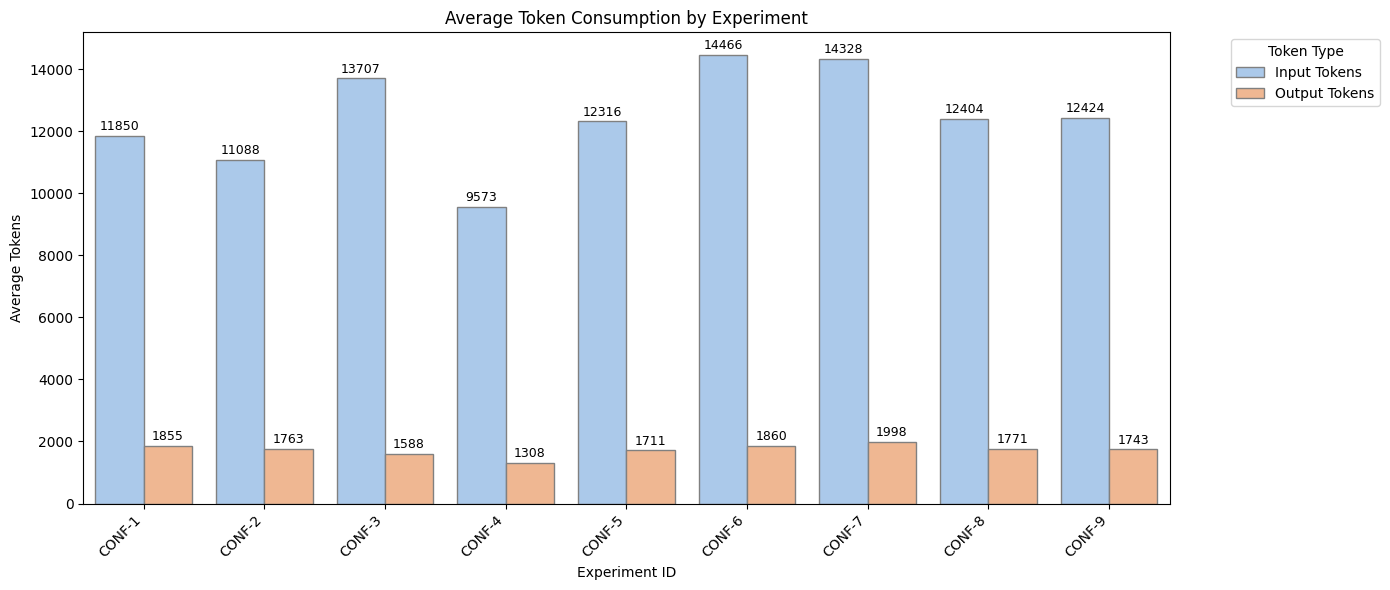

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute mean token usage by experiment
token_cols = [
    "tokens_consumed.input_tokens",
    "tokens_consumed.output_tokens",
]

mean_token_usage = df.groupby("experiment_name")[token_cols].mean().reset_index()

# Melt for plotting
melted = mean_token_usage.melt(
    id_vars="experiment_name",
    value_vars=token_cols,
    var_name="token_type",
    value_name="avg_tokens",
)

# Sort experiments numerically
melted["experiment_order"] = melted["experiment_name"].apply(
    lambda x: int(x.split("-")[1])
)
melted = melted.sort_values("experiment_order")
melted.drop(columns="experiment_order", inplace=True)

# Label mapping and pastel palette
token_type_mapping = {
    "tokens_consumed.input_tokens": "Input Tokens",
    "tokens_consumed.output_tokens": "Output Tokens",
}
melted["token_type"] = melted["token_type"].map(token_type_mapping)

# Plot
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    data=melted,
    x="experiment_name",
    y="avg_tokens",
    hue="token_type",
    palette=my_palette,
    edgecolor="gray",
)

# Add numeric labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", label_type="edge", fontsize=9, padding=2)

# Formatting
plt.title("Average Token Consumption by Experiment")
plt.ylabel("Average Tokens")
plt.xlabel("Experiment ID")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Token Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# BERTScore

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_58736/1686469102.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


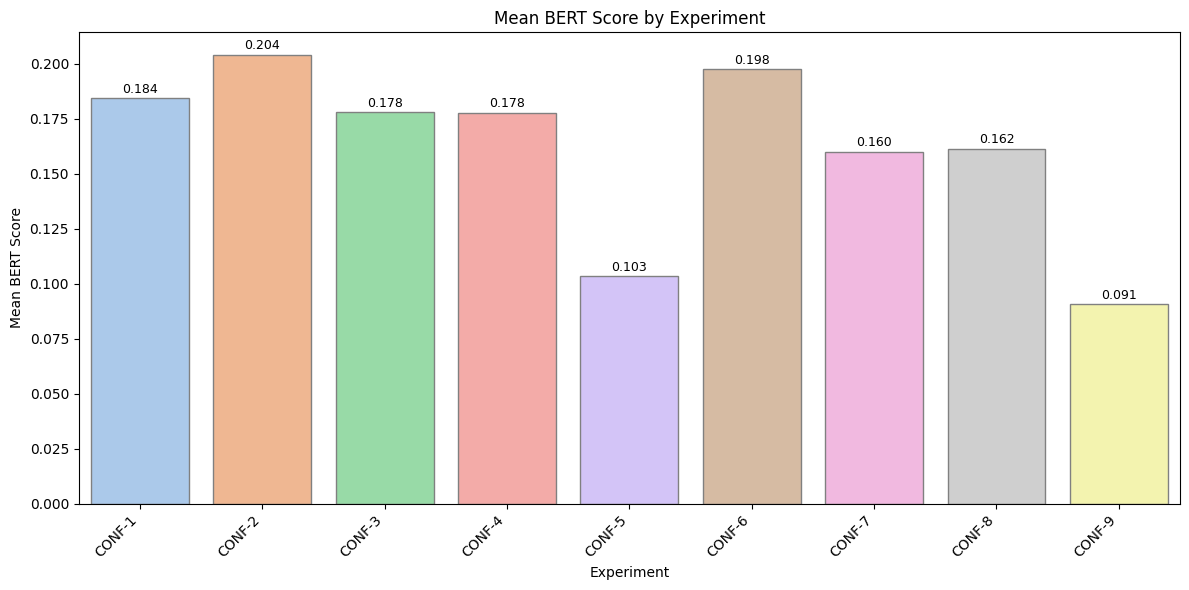

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the order from df
experiment_order = df["experiment_name"].unique()

# Compute mean BERT score per experiment
mean_bert = df.groupby("experiment_name")["bert_score"].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=mean_bert,
    x="experiment_name",
    y="bert_score",
    order=experiment_order,
    palette=my_palette,
    edgecolor="gray",
)

# Add numeric labels to bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type="edge", fontsize=9, padding=2)

# Formatting
plt.title("Mean BERT Score by Experiment")
plt.xlabel("Experiment")
plt.ylabel("Mean BERT Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_58736/748892668.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


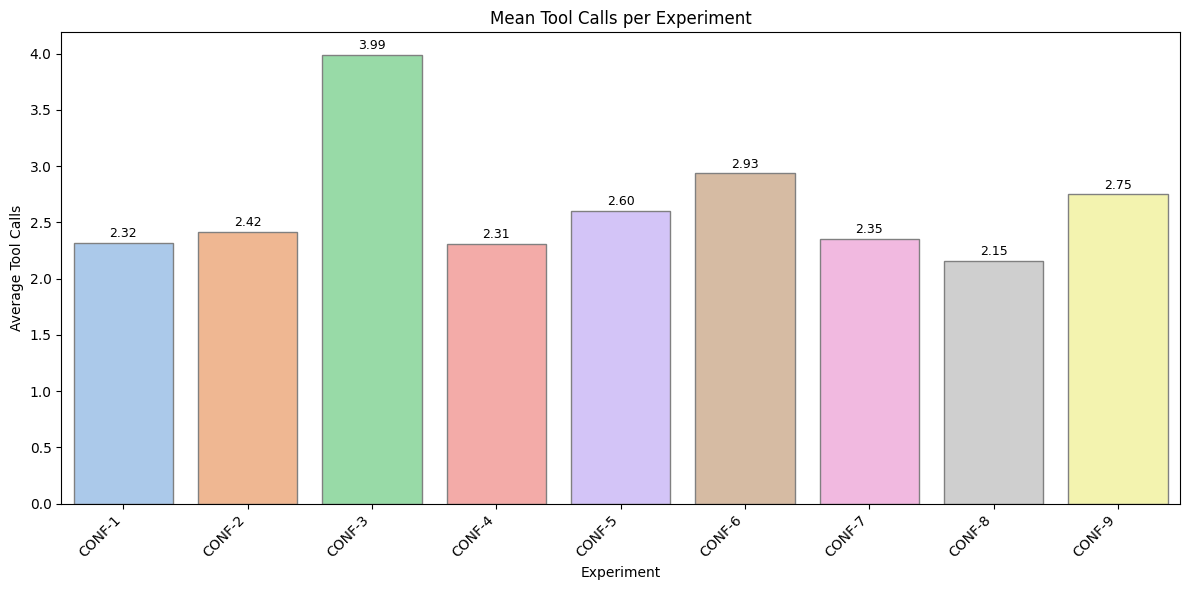

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the order from df
experiment_order = df["experiment_name"].unique()

# Compute mean tool calls per experiment
mean_tools = df.groupby("experiment_name")["tool_calls_count"].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=mean_tools,
    x="experiment_name",
    y="tool_calls_count",
    order=experiment_order,
    palette=my_palette,
    edgecolor="gray",
)

# Add numeric labels to bars, positioned just outside the top edge
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9, padding=2)

# Formatting
plt.title("Mean Tool Calls per Experiment")
plt.xlabel("Experiment")
plt.ylabel("Average Tool Calls")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()